#Time Series Anomaly Detection using a Kolmogorov Arnold Network

### Testing with Synthetic Anomaly Data

Total samples in dataset: 499
Number of positive samples in dataset: 103
Number of negative samples in dataset: 396
Train samples: 299, Val samples: 100, Test samples: 100
Train - Anomalies: 61, Normals: 238
Validation - Anomalies: 21, Normals: 79
Test - Anomalies: 21, Normals: 79
Balanced Training Set - Anomalies: 238, Normals: 238
Using pos_weight: 1.0000


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1, Training Positive Predictions: 285.0
Epoch: 0001, Train Loss: 0.0435, Train Acc: 0.5525, Val Loss: 0.0837, Val Acc: 0.3200, Precision: 0.2169, Recall: 0.8571, F1: 0.3462, ROC AUC: 0.5883, Optimal Threshold: 0.5811, Val F1: 0.3820
Epoch 2, Training Positive Predictions: 206.0
Epoch: 0002, Train Loss: 0.0433, Train Acc: 0.6050, Val Loss: 0.0288, Val Acc: 0.8400, Precision: 0.7778, Recall: 0.3333, F1: 0.4667, ROC AUC: 0.7553, Optimal Threshold: 0.4898, Val F1: 0.5161
Epoch 3, Training Positive Predictions: 209.0
Epoch: 0003, Train Loss: 0.0408, Train Acc: 0.6197, Val Loss: 0.0302, Val Acc: 0.8200, Precision: 0.6364, Recall: 0.3333, F1: 0.4375, ROC AUC: 0.6305, Optimal Threshold: 0.5496, Val F1: 0.5000
Epoch 4, Training Positive Predictions: 229.0
Epoch: 0004, Train Loss: 0.0386, Train Acc: 0.6576, Val Loss: 0.0276, Val Acc: 0.8500, Precision: 1.0000, Recall: 0.2857, F1: 0.4444, ROC AUC: 0.6938, Optimal Threshold: 0.4840, Val F1: 0.5000
Epoch 5, Training Positive Predictions: 208.

<ipython-input-1-1676d038a643>:454: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_kan_model.pth"))


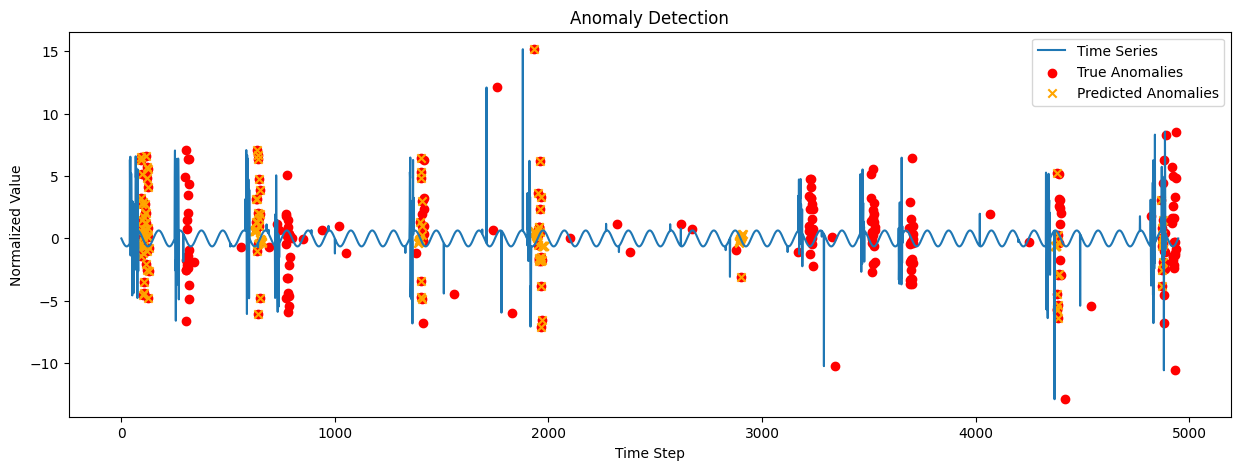

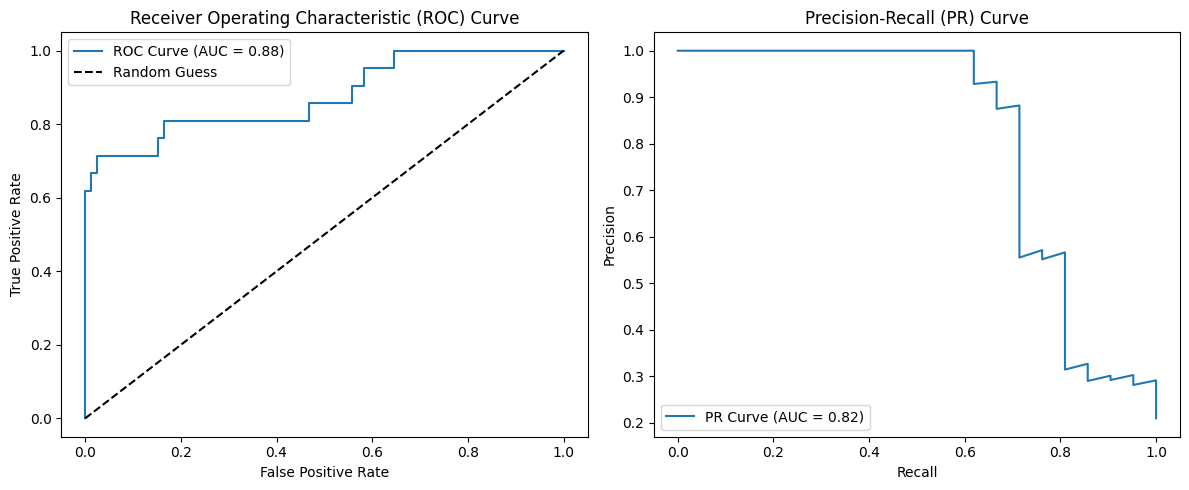

In [1]:
# -*- coding: utf-8 -*-
"""Improved KAN for Time Series Anomaly Detection with Enhancements"""

# Import necessary libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import random
from sklearn.metrics import (
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    precision_recall_curve,
    roc_curve,
    auc,
)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt

# Set random seeds for reproducibility
class Args:
    path = "./data/"
    dropout = 0.3
    hidden_size = 128
    grid_size = 50
    n_layers = 2
    epochs = 200
    early_stopping = 30  # Increased patience
    seed = 42
    lr = 1e-3  # Increased learning rate
    window_size = 20
    step_size = 10
    batch_size = 32
    anomaly_fraction = 0.1

args = Args()
args.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

random.seed(args.seed)
np.random.seed(args.seed)
torch.manual_seed(args.seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(args.seed)

# Generate synthetic time series data with diverse anomalies
def generate_sine_wave_with_anomalies(
    length=5000, anomaly_fraction=0.1, window_size=20, step_size=10
):
    x = np.linspace(0, 100 * np.pi, length)
    y = np.sin(x)
    labels = np.zeros(length)
    window_centers = list(range(window_size // 2, length - window_size // 2, step_size))
    num_anomalies = int(len(window_centers) * anomaly_fraction)
    anomaly_centers = np.random.choice(window_centers, num_anomalies, replace=False)
    for center in anomaly_centers:
        anomaly_type = np.random.choice(['point', 'contextual', 'collective'])
        if anomaly_type == 'point':
            y[center] += np.random.normal(0, 10)
            labels[center] = 1
        elif anomaly_type == 'contextual':
            y[center] = y[center] * np.random.uniform(1.5, 2.0)
            labels[center] = 1
        elif anomaly_type == 'collective':
            start = max(0, center - window_size // 2)
            end = min(length, center + window_size // 2)
            y[start:end] += np.random.normal(0, 5, size=end - start)
            labels[start:end] = 1  # Mark the entire window as anomalous
    return y, labels

time_series, labels = generate_sine_wave_with_anomalies(
    length=5000,
    anomaly_fraction=args.anomaly_fraction,
    window_size=args.window_size,
    step_size=args.step_size,
)

# Normalize the time series
scaler = StandardScaler()
time_series = scaler.fit_transform(time_series.reshape(-1, 1)).flatten()

# Define the custom dataset with overlapping windows
class TimeSeriesAnomalyDataset(torch.utils.data.Dataset):
    def __init__(
        self, time_series, labels, window_size=20, step_size=10, transform=None
    ):
        self.time_series = time_series
        self.labels = labels
        self.window_size = window_size
        self.step_size = step_size
        self.transform = transform
        self.sample_indices = list(
            range(0, len(time_series) - window_size + 1, step_size)
        )

    def __len__(self):
        return len(self.sample_indices)

    def __getitem__(self, idx):
        if idx >= len(self.sample_indices) or idx < 0:
            raise IndexError(
                f"Index {idx} out of range for sample_indices of length {len(self.sample_indices)}"
            )
        i = self.sample_indices[idx]
        window = self.time_series[i : i + self.window_size]
        window_labels = self.labels[i : i + self.window_size]

        # Input features: window values
        x = torch.tensor(window, dtype=torch.float).unsqueeze(-1)  # Shape: [window_size, 1]

        # Label: 1 if any point in the window is an anomaly, else 0
        y = torch.tensor(1.0 if window_labels.any() else 0.0, dtype=torch.float)

        return x, y

    def indices(self):
        return self.sample_indices

# Create the dataset
dataset = TimeSeriesAnomalyDataset(
    time_series,
    labels,
    window_size=args.window_size,
    step_size=args.step_size,
)

# Verify dataset length and class distribution
print(f"Total samples in dataset: {len(dataset)}")
num_pos = sum([y.item() for _, y in dataset])
num_neg = len(dataset) - num_pos
print(f"Number of positive samples in dataset: {int(num_pos)}")
print(f"Number of negative samples in dataset: {int(num_neg)}")

if num_pos == 0:
    raise ValueError(
        "No positive samples found in the dataset. Adjust window_size or step_size."
    )

# Stratified Splitting
def stratified_split(
    dataset, train_ratio=0.6, val_ratio=0.2, test_ratio=0.2, seed=42
):
    # Extract labels
    labels = [y.item() for _, y in dataset]

    # Split into train+val and test
    train_val_indices, test_indices = train_test_split(
        np.arange(len(labels)),
        test_size=test_ratio,
        stratify=labels,
        random_state=seed,
    )

    # Calculate validation size relative to train_val
    val_relative_ratio = val_ratio / (train_ratio + val_ratio)

    # Split train_val into train and val
    train_indices, val_indices = train_test_split(
        train_val_indices,
        test_size=val_relative_ratio,
        stratify=[labels[i] for i in train_val_indices],
        random_state=seed,
    )

    return train_indices, val_indices, test_indices

train_indices, val_indices, test_indices = stratified_split(dataset, seed=args.seed)

print(
    f"Train samples: {len(train_indices)}, Val samples: {len(val_indices)}, Test samples: {len(test_indices)}"
)

# Count anomalies in each set
def count_anomalies(dataset_subset, name):
    labels = [y.item() for _, y in dataset_subset]
    num_anomalies = int(sum(labels))
    num_normals = len(labels) - num_anomalies
    print(f"{name} - Anomalies: {num_anomalies}, Normals: {num_normals}")

train_dataset = torch.utils.data.Subset(dataset, train_indices)
val_dataset = torch.utils.data.Subset(dataset, val_indices)
test_dataset = torch.utils.data.Subset(dataset, test_indices)

count_anomalies(train_dataset, "Train")
count_anomalies(val_dataset, "Validation")
count_anomalies(test_dataset, "Test")

# Prepare data for SMOTE
X_train = [x.numpy().flatten() for x, _ in train_dataset]
y_train = [int(y.item()) for _, y in train_dataset]

# Implementing SMOTE for oversampling
smote = SMOTE(random_state=args.seed)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# Create a new dataset with the resampled data
class ResampledDataset(torch.utils.data.Dataset):
    def __init__(self, X, y):
        self.X = [torch.tensor(x, dtype=torch.float).view(-1, 1) for x in X]
        self.y = [torch.tensor(label, dtype=torch.float) for label in y]
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

balanced_train_dataset = ResampledDataset(X_resampled, y_resampled)

# Update the DataLoader
train_loader = torch.utils.data.DataLoader(
    balanced_train_dataset, batch_size=args.batch_size, shuffle=True
)
val_loader = torch.utils.data.DataLoader(
    val_dataset, batch_size=args.batch_size, shuffle=False
)
test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=args.batch_size, shuffle=False
)

# Recalculate class counts after oversampling
total_anomalies = y_resampled.count(1)
total_normals = y_resampled.count(0)
print(f"Balanced Training Set - Anomalies: {total_anomalies}, Normals: {total_normals}")

# Adjust the pos_weight for BCEWithLogitsLoss
pos_weight = total_normals / total_anomalies
print(f"Using pos_weight: {pos_weight:.4f}")

# Implement Focal Loss
class FocalLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction
    def forward(self, inputs, targets):
        BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
        pt = torch.exp(-BCE_loss)
        F_loss = self.alpha * ((1 - pt) ** self.gamma) * BCE_loss
        if self.reduction == 'mean':
            return F_loss.mean()
        else:
            return F_loss.sum()

criterion = FocalLoss(alpha=0.25, gamma=2)

# Corrected NaiveFourierKANLayer class
class NaiveFourierKANLayer(nn.Module):
    def __init__(self, inputdim, outdim, gridsize=50, addbias=True):
        super(NaiveFourierKANLayer, self).__init__()
        self.gridsize = gridsize
        self.addbias = addbias
        self.inputdim = inputdim
        self.outdim = outdim

        self.fouriercoeffs = nn.Parameter(
            torch.randn(2 * gridsize, inputdim, outdim)
            / (np.sqrt(inputdim) * np.sqrt(gridsize))
        )
        if self.addbias:
            self.bias = nn.Parameter(torch.zeros(outdim))

    def forward(self, x):
        # x shape: [batch_size, window_size, inputdim]
        batch_size, window_size, inputdim = x.size()
        k = torch.arange(1, self.gridsize + 1, device=x.device).float()
        k = k.view(1, 1, 1, self.gridsize)
        x_expanded = x.unsqueeze(-1)  # [batch_size, window_size, inputdim, 1]
        angles = x_expanded * k * np.pi  # [batch_size, window_size, inputdim, gridsize]
        sin_features = torch.sin(angles)
        cos_features = torch.cos(angles)
        features = torch.cat([sin_features, cos_features], dim=-1)  # Concatenate on gridsize dimension
        features = features.view(batch_size * window_size, inputdim, -1)  # Flatten for matmul
        coeffs = self.fouriercoeffs  # [2 * gridsize, inputdim, outdim]
        y = torch.einsum('bik,kio->bo', features, coeffs)
        y = y.view(batch_size, window_size, self.outdim)
        if self.addbias:
            y += self.bias
        return y

# Define the KAN model
class KAN(nn.Module):
    def __init__(
        self,
        in_feat,
        hidden_feat,
        out_feat,
        grid_feat,
        num_layers,
        use_bias=True,
        dropout=0.3,
    ):
        super(KAN, self).__init__()
        self.num_layers = num_layers
        self.lin_in = nn.Linear(in_feat, hidden_feat, bias=use_bias)
        self.bn_in = nn.BatchNorm1d(hidden_feat)
        self.dropout = nn.Dropout(p=dropout)
        self.layers = nn.ModuleList()
        self.bns = nn.ModuleList()
        for _ in range(num_layers):
            self.layers.append(
                NaiveFourierKANLayer(
                    hidden_feat, hidden_feat, grid_feat, addbias=use_bias
                )
            )
            self.bns.append(nn.BatchNorm1d(hidden_feat))
        self.lin_out = nn.Linear(hidden_feat, out_feat, bias=use_bias)

    def forward(self, x):
        # x shape: [batch_size, window_size, 1]
        batch_size, window_size, _ = x.size()
        x = self.lin_in(x)  # [batch_size, window_size, hidden_feat]
        x = self.bn_in(x.view(-1, x.size(-1))).view(batch_size, window_size, -1)
        x = F.leaky_relu(x, negative_slope=0.1)
        x = self.dropout(x)
        for layer, bn in zip(self.layers, self.bns):
            x = layer(x)
            x = bn(x.view(-1, x.size(-1))).view(batch_size, window_size, -1)
            x = F.leaky_relu(x, negative_slope=0.1)
            x = self.dropout(x)
        # Global average pooling over the window dimension
        x = x.mean(dim=1)  # [batch_size, hidden_feat]
        x = self.lin_out(x).squeeze()  # [batch_size]
        return x

# Initialize the model
model = KAN(
    in_feat=1,
    hidden_feat=args.hidden_size,
    out_feat=1,
    grid_feat=args.grid_size,
    num_layers=args.n_layers,
    use_bias=True,
    dropout=args.dropout,
).to(args.device)

# Define optimizer with weight decay for regularization
optimizer = torch.optim.Adam(model.parameters(), lr=args.lr, weight_decay=1e-5)

# Learning rate scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=5
)

# Define evaluation metrics
def evaluate_metrics(true_labels, pred_labels, pred_probs):
    precision = precision_score(true_labels, pred_labels, zero_division=0)
    recall = recall_score(true_labels, pred_labels, zero_division=0)
    f1 = f1_score(true_labels, pred_labels, zero_division=0)
    roc_auc_val = roc_auc_score(true_labels, pred_probs)
    return precision, recall, f1, roc_auc_val

# Function to determine optimal threshold based on validation set
def find_optimal_threshold(probs, labels):
    precision_vals, recall_vals, thresholds = precision_recall_curve(labels, probs)
    f1_scores = 2 * (precision_vals * recall_vals) / (precision_vals + recall_vals + 1e-8)
    optimal_idx = np.argmax(f1_scores)
    if optimal_idx < len(thresholds):
        optimal_threshold = thresholds[optimal_idx]
    else:
        optimal_threshold = 0.5  # Default threshold
    optimal_f1 = f1_scores[optimal_idx]
    return optimal_threshold, optimal_f1

# Training and validation loop with early stopping
best_val_f1 = 0
patience = args.early_stopping
patience_counter = 0
optimal_threshold = 0.5  # Initialize with default threshold

for epoch in range(args.epochs):
    # Training Phase
    model.train()
    total_loss = 0
    total_acc = 0
    total_preds_pos = 0  # Monitor number of positive predictions
    for x_batch, y_batch in train_loader:
        x_batch = x_batch.to(args.device)
        y_batch = y_batch.to(args.device)
        optimizer.zero_grad()
        out = model(x_batch)  # Output shape: [batch_size]
        loss = criterion(out, y_batch)
        loss.backward()
        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        total_loss += loss.item() * x_batch.size(0)
        probs = torch.sigmoid(out)
        preds = (probs > 0.5).float()
        acc = (preds == y_batch).float().mean().item()
        total_acc += acc * x_batch.size(0)
        total_preds_pos += preds.sum().item()
    avg_loss = total_loss / len(balanced_train_dataset)
    avg_acc = total_acc / len(balanced_train_dataset)

    print(f"Epoch {epoch+1}, Training Positive Predictions: {total_preds_pos}")

    # Validation Phase
    model.eval()
    val_loss = 0
    val_acc = 0
    all_true = []
    all_preds = []
    all_probs = []
    with torch.no_grad():
        for x_batch, y_batch in val_loader:
            x_batch = x_batch.to(args.device)
            y_batch = y_batch.to(args.device)
            out = model(x_batch)
            loss = criterion(out, y_batch)
            val_loss += loss.item() * x_batch.size(0)
            probs = torch.sigmoid(out)
            preds = (probs > 0.5).float()
            acc = (preds == y_batch).float().mean().item()
            val_acc += acc * x_batch.size(0)
            all_true.extend(y_batch.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
    avg_val_loss = val_loss / len(val_dataset)
    avg_val_acc = val_acc / len(val_dataset)
    precision, recall, f1, roc_auc_val = evaluate_metrics(all_true, all_preds, all_probs)

    # Find Optimal Threshold
    current_threshold, current_f1 = find_optimal_threshold(all_probs, all_true)

    print(
        f"Epoch: {epoch+1:04d}, "
        f"Train Loss: {avg_loss:.4f}, Train Acc: {avg_acc:.4f}, "
        f"Val Loss: {avg_val_loss:.4f}, Val Acc: {avg_val_acc:.4f}, "
        f"Precision: {precision:.4f}, Recall: {recall:.4f}, "
        f"F1: {f1:.4f}, ROC AUC: {roc_auc_val:.4f}, "
        f"Optimal Threshold: {current_threshold:.4f}, Val F1: {current_f1:.4f}"
    )

    # Step the scheduler
    scheduler.step(avg_val_loss)

    # Early Stopping
    if f1 > best_val_f1:
        best_val_f1 = f1
        patience_counter = 0
        optimal_threshold = current_threshold  # Update optimal threshold
        # Save the best model
        torch.save(model.state_dict(), "best_kan_model.pth")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

# Load the best model
model.load_state_dict(torch.load("best_kan_model.pth"))

# Test the model using the optimal threshold
model.eval()
test_loss = 0
test_acc = 0
all_true_test = []
all_preds_test = []
all_probs_test = []
with torch.no_grad():
    for x_batch, y_batch in test_loader:
        x_batch = x_batch.to(args.device)
        y_batch = y_batch.to(args.device)
        out = model(x_batch)
        loss = criterion(out, y_batch)
        test_loss += loss.item() * x_batch.size(0)
        probs = torch.sigmoid(out)
        preds = (probs > optimal_threshold).float()
        acc = (preds == y_batch).float().mean().item()
        test_acc += acc * x_batch.size(0)
        all_true_test.extend(y_batch.cpu().numpy())
        all_preds_test.extend(preds.cpu().numpy())
        all_probs_test.extend(probs.cpu().numpy())
avg_test_loss = test_loss / len(test_dataset)
avg_test_acc = test_acc / len(test_dataset)
precision, recall, f1, roc_auc_val = evaluate_metrics(
    all_true_test, all_preds_test, all_probs_test
)

print(
    f"\nTest Loss: {avg_test_loss:.4f}, Test Acc: {avg_test_acc:.4f}, "
    f"Precision: {precision:.4f}, Recall: {recall:.4f}, "
    f"F1: {f1:.4f}, ROC AUC: {roc_auc_val:.4f}"
)

# Visualization of anomalies
def plot_anomalies(time_series, labels, preds, start=0, end=1000):
    plt.figure(figsize=(15, 5))
    plt.plot(time_series[start:end], label="Time Series")
    plt.scatter(
        np.arange(start, end)[labels[start:end] == 1],
        time_series[start:end][labels[start:end] == 1],
        color="red",
        label="True Anomalies",
    )
    plt.scatter(
        np.arange(start, end)[preds[start:end] == 1],
        time_series[start:end][preds[start:end] == 1],
        color="orange",
        marker="x",
        label="Predicted Anomalies",
    )
    plt.legend()
    plt.title("Anomaly Detection")
    plt.xlabel("Time Step")
    plt.ylabel("Normalized Value")
    plt.show()

# Aggregate predictions on the test set
def aggregate_predictions(indices, preds, window_size, total_length):
    aggregated = np.zeros(total_length, dtype=float)
    counts = np.zeros(total_length, dtype=float)
    for idx, pred in zip(indices, preds):
        start = idx
        end = idx + window_size
        if end > total_length:
            end = total_length
        aggregated[start:end] += pred
        counts[start:end] += 1
    counts[counts == 0] = 1
    averaged = aggregated / counts
    return (averaged > 0.5).astype(int)

# Aggregate predictions
test_sample_indices = [dataset.sample_indices[i] for i in test_indices]
aggregated_preds = aggregate_predictions(
    test_sample_indices, all_preds_test, args.window_size, len(time_series)
)

# Plot anomalies on the test set
test_start = min(test_sample_indices)
test_end = max(test_sample_indices) + args.window_size
plot_anomalies(time_series, labels, aggregated_preds, start=test_start, end=test_end)

# Additional Visualization: ROC and Precision-Recall Curves
def plot_metrics(true_labels, pred_probs):
    # ROC Curve
    fpr, tpr, _ = roc_curve(true_labels, pred_probs)
    roc_auc_val = auc(fpr, tpr)

    # Precision-Recall Curve
    precision_vals, recall_vals, _ = precision_recall_curve(true_labels, pred_probs)
    pr_auc_val = auc(recall_vals, precision_vals)

    plt.figure(figsize=(12, 5))

    # ROC Curve
    plt.subplot(1, 2, 1)
    plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc_val:.2f})")
    plt.plot([0, 1], [0, 1], "k--", label="Random Guess")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Receiver Operating Characteristic (ROC) Curve")
    plt.legend()

    # Precision-Recall Curve
    plt.subplot(1, 2, 2)
    plt.plot(recall_vals, precision_vals, label=f"PR Curve (AUC = {pr_auc_val:.2f})")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall (PR) Curve")
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_metrics(all_true_test, all_probs_test)


### Testing with ECG_5000 Anomaly Dataset

Epoch 1, Training Positive Predictions: 3938.0
Epoch: 0001, Train Loss: 0.0882, Train Acc: 0.5090, Val Loss: 0.0926, Val Acc: 0.4160, Precision: 0.4160, Recall: 1.0000, F1: 0.5876, ROC AUC: 0.8211, Optimal Threshold: 0.5594, Val F1: 0.7476
Epoch 2, Training Positive Predictions: 2605.0
Epoch: 0002, Train Loss: 0.0816, Train Acc: 0.6976, Val Loss: 0.0737, Val Acc: 0.8280, Precision: 0.8020, Recall: 0.7788, F1: 0.7902, ROC AUC: 0.8783, Optimal Threshold: 0.4922, Val F1: 0.8292
Epoch 3, Training Positive Predictions: 1973.0
Epoch: 0003, Train Loss: 0.0762, Train Acc: 0.7645, Val Loss: 0.0644, Val Acc: 0.8400, Precision: 0.7991, Recall: 0.8221, F1: 0.8104, ROC AUC: 0.8791, Optimal Threshold: 0.4626, Val F1: 0.8323
Epoch 4, Training Positive Predictions: 2028.0
Epoch: 0004, Train Loss: 0.0671, Train Acc: 0.7942, Val Loss: 0.0655, Val Acc: 0.7200, Precision: 0.7881, Recall: 0.4471, F1: 0.5706, ROC AUC: 0.8886, Optimal Threshold: 0.3634, Val F1: 0.8553
Epoch 5, Training Positive Predictions: 

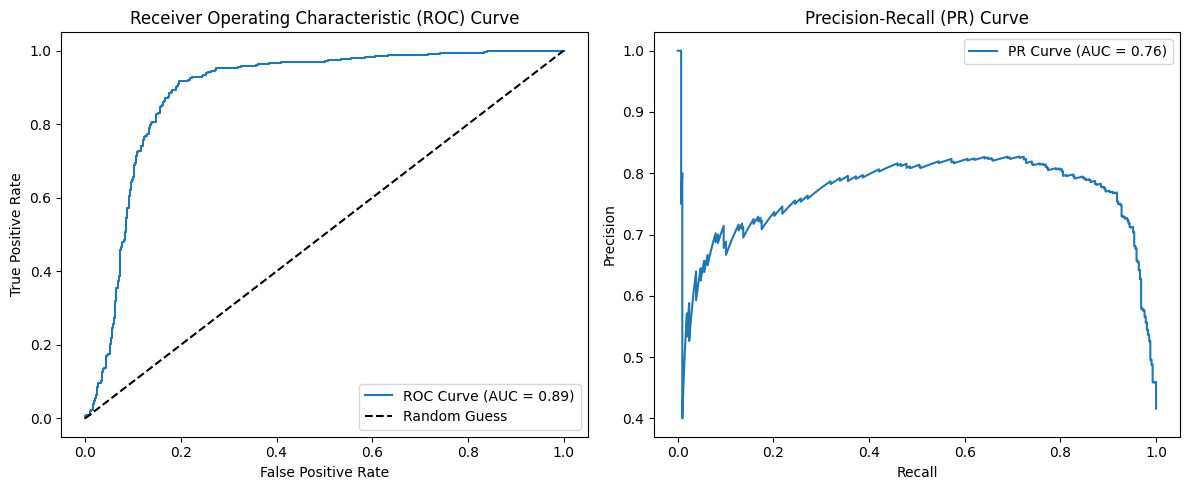

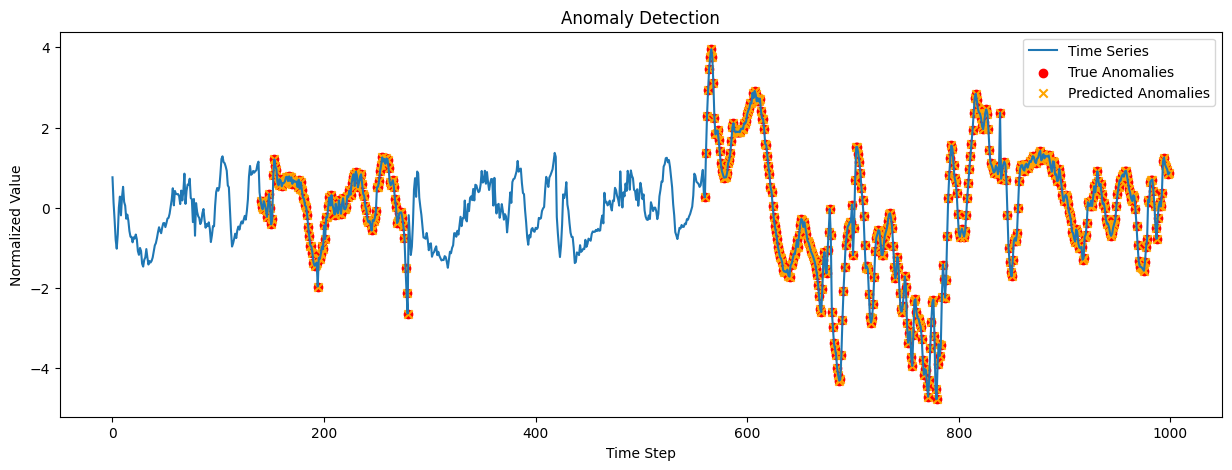

In [2]:
# -*- coding: utf-8 -*-
"""Final Improved KAN Anomaly Detection on ECG5000 Dataset with Visualization"""

# Import necessary libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import random
from sklearn.metrics import (
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    precision_recall_curve,
    roc_curve,
    auc,
)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.combine import SMOTEENN
import matplotlib.pyplot as plt
import pandas as pd
import os
from scipy.io import arff

# Set random seeds for reproducibility
class Args:
    dropout = 0.3
    hidden_size = 128
    grid_size = 50
    n_layers = 2
    epochs = 50
    early_stopping = 10
    seed = 42
    lr = 1e-4  # Reduced learning rate
    batch_size = 64

args = Args()
args.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

random.seed(args.seed)
np.random.seed(args.seed)
torch.manual_seed(args.seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(args.seed)

# Load and preprocess the ECG5000 dataset
def load_ecg5000_dataset():
    if not os.path.isfile("ECG5000_TRAIN.arff") or not os.path.isfile("ECG5000_TEST.arff"):
        raise FileNotFoundError("ECG5000_TRAIN.arff and ECG5000_TEST.arff not found in the current directory.")

    data_train, meta_train = arff.loadarff('ECG5000_TRAIN.arff')
    df_train = pd.DataFrame(data_train)
    data_test, meta_test = arff.loadarff('ECG5000_TEST.arff')
    df_test = pd.DataFrame(data_test)

    df_all = pd.concat([df_train, df_test], ignore_index=True)
    labels = df_all.iloc[:, -1].values
    labels = np.array([label.decode('utf-8') if isinstance(label, bytes) else label for label in labels])
    time_series = df_all.iloc[:, :-1].values.astype(np.float32)
    labels = np.where(labels == '1', 0, 1)
    return time_series, labels

time_series, labels = load_ecg5000_dataset()

# Normalize the time series
scaler = StandardScaler()
time_series = scaler.fit_transform(time_series)

# Stratified Splitting
def stratified_split(X, y, test_ratio=0.2, val_ratio=0.1, seed=42):
    X_train_val, X_test, y_train_val, y_test = train_test_split(
        X, y,
        test_size=test_ratio,
        stratify=y,
        random_state=seed,
    )
    val_relative_ratio = val_ratio / (1 - test_ratio)
    X_train, X_val, y_train, y_val = train_test_split(
        X_train_val,
        y_train_val,
        test_size=val_relative_ratio,
        stratify=y_train_val,
        random_state=seed,
    )
    return X_train, y_train, X_val, y_val, X_test, y_test

X_train, y_train, X_val, y_val, X_test, y_test = stratified_split(
    time_series, labels, seed=args.seed
)

# Implementing SMOTEENN for oversampling and cleaning
smote_enn = SMOTEENN(random_state=args.seed)
X_resampled, y_resampled = smote_enn.fit_resample(X_train, y_train)

# Convert data to tensors
def create_dataset(X, y):
    X_tensor = torch.tensor(X, dtype=torch.float32)
    y_tensor = torch.tensor(y, dtype=torch.float32)
    return torch.utils.data.TensorDataset(X_tensor.unsqueeze(-1), y_tensor)

train_dataset = create_dataset(X_resampled, y_resampled)
val_dataset = create_dataset(X_val, y_val)
test_dataset = create_dataset(X_test, y_test)

# DataLoaders
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=args.batch_size, shuffle=True
)
val_loader = torch.utils.data.DataLoader(
    val_dataset, batch_size=args.batch_size, shuffle=False
)
test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=args.batch_size, shuffle=False
)

# Implement Focal Loss with adjusted parameters
class FocalLoss(nn.Module):
    def __init__(self, alpha=0.5, gamma=2, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction
    def forward(self, inputs, targets):
        BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
        pt = torch.exp(-BCE_loss)
        F_loss = self.alpha * ((1 - pt) ** self.gamma) * BCE_loss
        if self.reduction == 'mean':
            return F_loss.mean()
        else:
            return F_loss.sum()

criterion = FocalLoss(alpha=0.5, gamma=2)

# Corrected NaiveFourierKANLayer class
class NaiveFourierKANLayer(nn.Module):
    def __init__(self, inputdim, outdim, gridsize=50, addbias=True):
        super(NaiveFourierKANLayer, self).__init__()
        self.gridsize = gridsize
        self.addbias = addbias
        self.inputdim = inputdim
        self.outdim = outdim

        self.fouriercoeffs = nn.Parameter(
            torch.randn(2 * gridsize, inputdim, outdim)
            / (np.sqrt(inputdim) * np.sqrt(gridsize))
        )
        if self.addbias:
            self.bias = nn.Parameter(torch.zeros(outdim))

    def forward(self, x):
        batch_size, sequence_length, inputdim = x.size()
        k = torch.arange(1, self.gridsize + 1, device=x.device).float()
        k = k.view(1, 1, 1, self.gridsize)
        x_expanded = x.unsqueeze(-1)
        angles = x_expanded * k * np.pi
        sin_features = torch.sin(angles)
        cos_features = torch.cos(angles)
        features = torch.cat([sin_features, cos_features], dim=-1)
        features = features.view(batch_size * sequence_length, inputdim, -1)
        coeffs = self.fouriercoeffs
        y = torch.einsum('bik,kio->bo', features, coeffs)
        y = y.view(batch_size, sequence_length, self.outdim)
        if self.addbias:
            y += self.bias
        return y

# Define the KAN model
class KAN(nn.Module):
    def __init__(
        self,
        in_feat,
        hidden_feat,
        out_feat,
        grid_feat,
        num_layers,
        use_bias=True,
        dropout=0.3,
    ):
        super(KAN, self).__init__()
        self.num_layers = num_layers
        self.lin_in = nn.Linear(in_feat, hidden_feat, bias=use_bias)
        self.bn_in = nn.BatchNorm1d(hidden_feat)
        self.dropout = nn.Dropout(p=dropout)
        self.layers = nn.ModuleList()
        self.bns = nn.ModuleList()
        for _ in range(num_layers):
            self.layers.append(
                NaiveFourierKANLayer(
                    hidden_feat, hidden_feat, grid_feat, addbias=use_bias
                )
            )
            self.bns.append(nn.BatchNorm1d(hidden_feat))
        self.lin_out = nn.Linear(hidden_feat, out_feat, bias=use_bias)

    def forward(self, x):
        batch_size, sequence_length, _ = x.size()
        x = self.lin_in(x)
        x = self.bn_in(x.view(-1, x.size(-1))).view(batch_size, sequence_length, -1)
        x = F.leaky_relu(x, negative_slope=0.1)
        x = self.dropout(x)
        for layer, bn in zip(self.layers, self.bns):
            x = layer(x)
            x = bn(x.view(-1, x.size(-1))).view(batch_size, sequence_length, -1)
            x = F.leaky_relu(x, negative_slope=0.1)
            x = self.dropout(x)
        x = x.mean(dim=1)
        x = self.lin_out(x).squeeze()
        return x

# Initialize the model
model = KAN(
    in_feat=1,
    hidden_feat=args.hidden_size,
    out_feat=1,
    grid_feat=args.grid_size,
    num_layers=args.n_layers,
    use_bias=True,
    dropout=args.dropout,
).to(args.device)

# Define optimizer with weight decay for regularization
optimizer = torch.optim.Adam(model.parameters(), lr=args.lr, weight_decay=1e-5)

# Learning rate scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=5
)

# Define evaluation metrics
def evaluate_metrics(true_labels, pred_labels, pred_probs):
    precision = precision_score(true_labels, pred_labels, zero_division=0)
    recall = recall_score(true_labels, pred_labels, zero_division=0)
    f1 = f1_score(true_labels, pred_labels, zero_division=0)
    roc_auc_val = roc_auc_score(true_labels, pred_probs)
    return precision, recall, f1, roc_auc_val

def find_optimal_threshold(probs, labels):
    precision_vals, recall_vals, thresholds = precision_recall_curve(labels, probs)
    f1_scores = 2 * (precision_vals * recall_vals) / (precision_vals + recall_vals + 1e-8)
    optimal_idx = np.argmax(f1_scores)
    if optimal_idx < len(thresholds):
        optimal_threshold = thresholds[optimal_idx]
    else:
        optimal_threshold = 0.5
    optimal_f1 = f1_scores[optimal_idx]
    return optimal_threshold, optimal_f1

# Training and validation loop with early stopping
best_val_f1 = 0
patience = args.early_stopping
patience_counter = 0
optimal_threshold = 0.5

for epoch in range(args.epochs):
    # Training Phase
    model.train()
    total_loss = 0
    total_acc = 0
    total_preds_pos = 0
    for x_batch, y_batch in train_loader:
        x_batch = x_batch.to(args.device)
        y_batch = y_batch.to(args.device)
        optimizer.zero_grad()
        # On-the-fly data augmentation
        noise = torch.randn_like(x_batch) * 0.05
        x_batch_noisy = x_batch + noise
        out = model(x_batch_noisy)
        loss = criterion(out, y_batch)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        total_loss += loss.item() * x_batch.size(0)
        probs = torch.sigmoid(out)
        preds = (probs > 0.5).float()
        acc = (preds == y_batch).float().mean().item()
        total_acc += acc * x_batch.size(0)
        total_preds_pos += preds.sum().item()
    avg_loss = total_loss / len(train_dataset)
    avg_acc = total_acc / len(train_dataset)

    print(f"Epoch {epoch+1}, Training Positive Predictions: {total_preds_pos}")

    # Validation Phase
    model.eval()
    val_loss = 0
    val_acc = 0
    all_true = []
    all_preds = []
    all_probs = []
    with torch.no_grad():
        for x_batch, y_batch in val_loader:
            x_batch = x_batch.to(args.device)
            y_batch = y_batch.to(args.device)
            out = model(x_batch)
            loss = criterion(out, y_batch)
            val_loss += loss.item() * x_batch.size(0)
            probs = torch.sigmoid(out)
            preds = (probs > 0.5).float()
            acc = (preds == y_batch).float().mean().item()
            val_acc += acc * x_batch.size(0)
            all_true.extend(y_batch.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
    avg_val_loss = val_loss / len(val_dataset)
    avg_val_acc = val_acc / len(val_dataset)
    precision, recall, f1, roc_auc_val = evaluate_metrics(all_true, all_preds, all_probs)

    # Find Optimal Threshold
    current_threshold, current_f1 = find_optimal_threshold(all_probs, all_true)

    print(
        f"Epoch: {epoch+1:04d}, "
        f"Train Loss: {avg_loss:.4f}, Train Acc: {avg_acc:.4f}, "
        f"Val Loss: {avg_val_loss:.4f}, Val Acc: {avg_val_acc:.4f}, "
        f"Precision: {precision:.4f}, Recall: {recall:.4f}, "
        f"F1: {f1:.4f}, ROC AUC: {roc_auc_val:.4f}, "
        f"Optimal Threshold: {current_threshold:.4f}, Val F1: {current_f1:.4f}"
    )

    # Step the scheduler
    scheduler.step(avg_val_loss)

    # Early Stopping
    if f1 > best_val_f1:
        best_val_f1 = f1
        patience_counter = 0
        optimal_threshold = current_threshold
        torch.save(model.state_dict(), "best_kan_model.pth")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

# Load the best model
model.load_state_dict(torch.load("best_kan_model.pth", weights_only=True))

# Test the model using the optimal threshold
model.eval()
test_loss = 0
test_acc = 0
all_true_test = []
all_preds_test = []
all_probs_test = []
with torch.no_grad():
    for x_batch, y_batch in test_loader:
        x_batch = x_batch.to(args.device)
        y_batch = y_batch.to(args.device)
        out = model(x_batch)
        loss = criterion(out, y_batch)
        test_loss += loss.item() * x_batch.size(0)
        probs = torch.sigmoid(out)
        # Adjust threshold to improve precision
        preds = (probs > optimal_threshold).float()
        acc = (preds == y_batch).float().mean().item()
        test_acc += acc * x_batch.size(0)
        all_true_test.extend(y_batch.cpu().numpy())
        all_preds_test.extend(preds.cpu().numpy())
        all_probs_test.extend(probs.cpu().numpy())
# Convert lists to numpy arrays
all_true_test = np.array(all_true_test)
all_preds_test = np.array(all_preds_test)
all_probs_test = np.array(all_probs_test)
avg_test_loss = test_loss / len(test_dataset)
avg_test_acc = test_acc / len(test_dataset)
precision, recall, f1, roc_auc_val = evaluate_metrics(
    all_true_test, all_preds_test, all_probs_test
)

print(
    f"\nTest Loss: {avg_test_loss:.4f}, Test Acc: {avg_test_acc:.4f}, "
    f"Precision: {precision:.4f}, Recall: {recall:.4f}, "
    f"F1: {f1:.4f}, ROC AUC: {roc_auc_val:.4f}"
)

# Additional Visualization: ROC and Precision-Recall Curves
def plot_metrics(true_labels, pred_probs):
    # ROC Curve
    fpr, tpr, _ = roc_curve(true_labels, pred_probs)
    roc_auc_val = auc(fpr, tpr)

    # Precision-Recall Curve
    precision_vals, recall_vals, _ = precision_recall_curve(true_labels, pred_probs)
    pr_auc_val = auc(recall_vals, precision_vals)

    plt.figure(figsize=(12, 5))

    # ROC Curve
    plt.subplot(1, 2, 1)
    plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc_val:.2f})")
    plt.plot([0, 1], [0, 1], "k--", label="Random Guess")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Receiver Operating Characteristic (ROC) Curve")
    plt.legend()

    # Precision-Recall Curve
    plt.subplot(1, 2, 2)
    plt.plot(recall_vals, precision_vals, label=f"PR Curve (AUC = {pr_auc_val:.2f})")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall (PR) Curve")
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_metrics(all_true_test, all_probs_test)

# Visualization of anomalies
# Flatten the test time series data into one long time series
X_test_np = X_test.squeeze()  # Shape: [num_samples, sequence_length]
long_time_series = X_test_np.reshape(-1)

# Expand the labels and predictions to match the time steps
expanded_labels = np.repeat(y_test, X_test_np.shape[1])
expanded_preds = np.repeat(all_preds_test, X_test_np.shape[1])

# Define the function to plot anomalies
def plot_anomalies(time_series, labels, preds, start=0, end=None):
    if end is None:
        end = len(time_series)
    plt.figure(figsize=(15, 5))
    plt.plot(np.arange(start, end), time_series[start:end], label="Time Series")
    # True anomalies
    anomaly_indices = np.where(labels[start:end] == 1)[0]
    plt.scatter(
        anomaly_indices + start,
        time_series[start:end][labels[start:end] == 1],
        color="red",
        label="True Anomalies",
    )
    # Predicted anomalies
    pred_anomaly_indices = np.where(preds[start:end] == 1)[0]
    plt.scatter(
        pred_anomaly_indices + start,
        time_series[start:end][preds[start:end] == 1],
        color="orange",
        marker="x",
        label="Predicted Anomalies",
    )
    plt.legend()
    plt.title("Anomaly Detection")
    plt.xlabel("Time Step")
    plt.ylabel("Normalized Value")
    plt.show()

# Plotting the anomalies
plot_anomalies(long_time_series, expanded_labels, expanded_preds, start=0, end=1000)
